In [141]:
'''
Algoritmo Recocido Simulado
De manera conceptual
1. Estado inicial = T
2. T = caliente
3. Repita hasta que T= frío
4. Perturbe el sistema (genere un estado al azar con distancia proporcional a T)
5. Calcule la energía del sistema
6. Si ΔE es < 0
 Entonces acepte el nuevo estado
 Sino acepte el nuevo estado con probabilidad = exp(-ΔE/KT}
7. Si ΔE < 0 decreció en las últimas x temperaturas
 Entonces T=0.9*T
 Sino T=frío
7. Retorne con el sistema en el último estado

Y llevado a código:
i := iinic ; i es la solución actual
f(i) := f eval inicial ; f es la función de evaluación a minimizar
Repite
For T:= Tinic to 1 do; Tinic es la temperatura Inicial del sistema
{Generar j ϵ Sj; (S es el espacio de soluciones)
Si f(j) < f(i)
entonces i := j
sino, si exp[ f(i)-f(j)/C.T] > random [0,1]
entonces i := j
T:= T-1
Si f(i)= f(iT+n) entonces return f(i)
}
'''
import matplotlib.pyplot as plt
import random
import pickle
import os
import json
import logging
import math
from datetime import datetime, timedelta

'''
Voy a modelar el algoritmo para que al principio tome como primer camino válido el tomado desde una ciudad en particular (elegir una al azar) y tomar el mínimo costo de llegar hacia otra ciudad (el minimo de todos los posibles desde dicha ciudad) y sige iterando hasta llegar a la última ciudad y sumarle el costo de llegar desde la última hasta la primera
Para perturbar al sistema voy a hacer un shuffle de las ciudades dentro del vector camino_actual dejando fijas una cierta cantidad de ciudades en base a su costo (los N menores recorridos quedaran fijos luego del shuffle, este valor N depende directamente de T, cuanto mas chico T más chico N hasta un máximo de cantCiudades-1)

Para las pruebas se tomarán los problemas con Geometria euclideana en 2D: att48, kroB100, kroB150, kroB200, rat575.
Opcionalmente se realizarán pruebas con eil51, berlin52, st70, eil76, eil101, tsp225, att532 y rat783.
'''

def _leerArchConf(tipo, archivo):
    arch = open(archivo)
    if (tipo is "TSPLIB"):
        # Las primeras 3 lineas del archivo se obvian
        for a in range(3):
            arch.readline()
        # Se lee la dimension del problema
        cantCiu = int(arch.readline().split("DIMENSION: ")[1])
        # Las siguientes 2 lineas del archivo se obvian
        for a in range(2):
            arch.readline()

        vec_ciudades = []
        vec_ciudades_map = []

        line = arch.readline()
        aux = [a for a in line.split(' ') if a is not '' and a is not '\n']
        while (line != 'EOF\n'):
            vec_ciudades.append([int(a) for a in aux])
            line = arch.readline()
            aux = [a for a in line.split(' ') if a is not '' and a is not '\n']

        # Se arman las tuplas de ciudades [(nro1, [x1, y1]),(nro2, [x2, y2]),...]
        vec_ciudades_map.append(map(lambda e: (e[0], e[1:]), vec_ciudades))

        # Se arma la lista de las tuplas de ciudades
        vec_ciudades_list = [list(a) for a in vec_ciudades_map][0]

        vec_costCiu = []
        aux = [a for a in vec_ciudades_list]
        while (len(aux) > 0):
            ciudad_actual = aux.pop(0)
            for b in aux:
                costo_x = (ciudad_actual[1][0] - b[1][0])**2
                costo_y = (ciudad_actual[1][1] - b[1][1])**2
                costo = (costo_x+costo_y)**(1/2)
                vec_costCiu.append(costo)
    elif (tipo is "TSP_IN"):
        cantCiu = int(arch.readline().split(';')[0])
        vec_costCiu = [int(a) for a in arch.readline().split(';') if a != '\n']
        vecmat_costCiu = []
    else:
        return -1

    arch.close()

    vecmat_costCiu = []
    vec_costCiu_aux = [a for a in vec_costCiu]
    for a in range(cantCiu):
        
        #TODO: optimizar -> c no se usa y se puede hacer mejor un append con ceros
        # Se inicializa en ceros el vector de costos de las ciudades que se utilizara para llenar la matriz de costos
        for c in range(a+1):
            vecmat_costCiu.append(0)
        
        # se llena el triangulo superior de la matriz
        for b in range(cantCiu-a-1):
            vecmat_costCiu.append(vec_costCiu_aux[0])
            vec_costCiu_aux = vec_costCiu_aux[1:]

    # se traspone el triangulo superior y se almacenan sus valores
    for a in range(cantCiu):
        for b in range(cantCiu):
            if b < a:
                # si la columna es menor a la fila, se copia el valor de su opuesto
                vecmat_costCiu[cantCiu*a+b] = vecmat_costCiu[cantCiu*b+a]

    # se termina de componer la matriz
    mat_costCiu = []
    for a in range(cantCiu):
        mat_costCiu.append(vecmat_costCiu[:cantCiu])
        vecmat_costCiu = vecmat_costCiu[cantCiu:]

    # se compone el objeto (dict) para agilizar el calculo de costos (costo de N a M).
    obj_costCiu = dict()
    for a in range(1,cantCiu+1):
        indice_1 = "ciudad{}".format(a)
        obj_costCiu[indice_1] = dict()
        for b in range(1,cantCiu+1):
            if (a is not b):
                indice_2 = "ciudad{}".format(b)
                obj_costCiu[indice_1][indice_2] = mat_costCiu[a-1][b-1]

    return cantCiu, vec_costCiu, mat_costCiu, obj_costCiu

def obtenerCantidadPerturbacionesLineal(cantCiu, t, T):
    perturbaciones = (cantCiu*t)/T
    if (perturbaciones <= 1):
        perturbaciones = 1
    elif (perturbaciones > cantCiu):
        perturbaciones = cantCiu
    return int(perturbaciones)

def generarPrimerCamino(mat_costCiu, cantCiu, n_ciudad_inicio):
    return generarPrimerCamino_fijo(mat_costCiu, cantCiu, n_ciudad_inicio, tomar="MENOR")
    #return generarPrimerCamino_azar(cantCiu)

def generarPrimerCamino_azar(cantCiu):
    recorrido = []
    for a in range(cantCiu):
        ciudad = random.randint(1,cantCiu)
        while ciudad in recorrido:
            ciudad = random.randint(1,cantCiu)
        recorrido.append(ciudad)
    return recorrido

def generarPrimerCamino_fijo(mat_costCiu, cantCiu, n_ciudad_inicio, tomar="MENOR"):
    # Se obtiene una primer solución a partir de una ciudad tomada de manera aleatoria y recorriendo la ciudad de menor costo.
    aux = []
    for a in mat_costCiu:
        vec = []
        for b in a:
            vec.append(b)
        aux.append(vec)

    recorrido = []
    ciudad_actual = n_ciudad_inicio
    recorrido.append(ciudad_actual)
    while (len(recorrido) < cantCiu):
        for a in recorrido:
            aux[ciudad_actual-1][a-1] = -1
        if (tomar is "MENOR"):
            ciudad_actual = 1 + aux[ciudad_actual-1].index(min([a for a in aux[ciudad_actual-1] if (a is not -1 and a is not 0)]))
        if (tomar is "MAYOR"):
            ciudad_actual = 1 + aux[ciudad_actual-1].index(max([a for a in aux[ciudad_actual-1] if (a is not -1 and a is not 0)]))
        recorrido.append(ciudad_actual)
    return recorrido

def calcularCostoRecorrido(mat_costCiu, recorrido_actual):
    aux = [a for a in mat_costCiu]
    costo_rec_actual = 0
    costo = 0
    costos = []
    for a in range(len(recorrido_actual)-1):
        costo = aux[recorrido_actual[a]-1][recorrido_actual[a+1]-1]
        costos.append(costo)
        costo_rec_actual += costo
    costo = aux[recorrido_actual[-1:][0]-1][recorrido_actual[0]-1]
    costos.append(costo)
    costo_rec_actual += costo
    return costo_rec_actual, costos

def generarPerturbacion(metodo, mat_costCiu, cantCiu, recorrido_actual, t, T, factor_de_aprendizaje):
    # Caóticas
    if (metodo is "SIMPLE"):
        return generarPerturbacion_simple(recorrido_actual)
    elif (metodo is "MOVIMIENTO_SIMPLE"):
        return generarPerturbacion_movimiento_simple(recorrido_actual)
    elif (metodo is "MOVIMIENTO_ALEDAÑO_POSTERIOR"):
        return generarPerturbacion_movimiento_aledanio_posterior(recorrido_actual)
    elif (metodo is "MOVIMIENTO_ALEDAÑO_ANTERIOR"):
        return generarPerturbacion_movimiento_aledanio_anterior(recorrido_actual)
    elif (metodo is "INTERCAMBIO_RANGO_SELECTIVO" or metodo is "STANDARD" or metodo is "CROES"):
        return generarPerturbacion_intercambio_rango_selectivo(cantCiu, recorrido_actual, t, T)
    elif (metodo is "INTERCAMBIOS_RANGO_SELECTIVO"):
        return generarPerturbaciones_intercambios_rango_selectivo(cantCiu, recorrido_actual, t, T)
    
    # Decrementales (convergente)
    elif (metodo is "SIMPLES"):
        return generarPerturbaciones_simples(cantCiu, recorrido_actual, t, T)
    elif (metodo is "MOVIMIENTOS_SIMPLES"):
        return generarPerturbaciones_movimientos_simples(recorrido_actual)

    #si no se elige ningun metodo optar por el mas sencillo
    else:
        return generarPerturbacion_simple(recorrido_actual)
    #return generarPerturbacion_compleja(mat_costCiu, cantCiu, recorrido_actual, t, T, factor_de_aprendizaje)

def generarPerturbacion_simple(recorrido_actual):
    # Caótico
    # Se intercambian 2 ciudades tomadas al azar en el recorrido
    # "mejores" parámetros T=2000, C=4
    recorrido_posible = [a for a in recorrido_actual]
    x = random.randint(0,len(recorrido_posible)-1)
    y = x
    while (x == y):
        y = random.randint(0,len(recorrido_posible)-1)
    aux = recorrido_posible[x]
    recorrido_posible[x] = recorrido_posible[y]
    recorrido_posible[y] = aux
    return recorrido_posible

def generarPerturbaciones_simples(cantCiu, recorrido_actual, t, T):
    # Decremental (convergente)
    # Se intercambian 2 ciudades tomadas al azar en el recorrido N veces (depende de t y T => cuanto menor es t menor la cantidad de perturbaciones)
    # "mejores" parámetros T=2000, C=3.5 ("equilibrio" en 1800 iteraciones). Ver C=5 que tiene un "equilibrio" en aprox 1000 iteraciones
    perturbaciones = obtenerCantidadPerturbacionesLineal(cantCiu, t, T)
    recorrido_posible = [a for a in recorrido_actual]
    for a in range(perturbaciones):
        recorrido_posible = generarPerturbacion_simple(recorrido_posible)
    return recorrido_posible

def generarPerturbacion_movimiento_simple(recorrido_actual):
    # Caótico
    # Se quita una ciudad del recorrido y se la agrega al final del vector. Equivale a desplazar elementos hacia la izquierda 1 posición y colocar la ciudad a "quitar" al final de dichos elementos
    # "mejores" parámetros T=2000, C=0.8
    recorrido_posible = [a for a in recorrido_actual]
    ciudad = recorrido_posible.pop(random.randint(0,len(recorrido_posible)-1))
    recorrido_posible.append(ciudad)
    return recorrido_posible

def generarPerturbaciones_movimientos_simples(recorrido_actual):
    # Decremental (convergente)
    # Se quita una ciudad del recorrido y se la agrega al final del vector N veces (depende de t y T => cuanto menor es t menor la cantidad de perturbaciones)
    # "mejores" parámetros T=2000, C=3.4
    perturbaciones = obtenerCantidadPerturbacionesLineal(cantCiu, t, T)
    recorrido_posible = [a for a in recorrido_actual]
    for a in range(perturbaciones):
        recorrido_posible = generarPerturbacion_movimiento_simple(recorrido_posible)
    return recorrido_posible

def generarPerturbacion_movimiento_aledanio_posterior(recorrido_actual):
    # Caótico
    # Se intercambia una ciudad del recorrido por su posterior. Es un caso particular de la Perturbacion_simple
    # "mejores" parámetros T=2000, C=0.3 (bajo deltaE promedio entre iteraciones pero con picos elevados). Ver C=0.4 picos positivos elevadisimos
    recorrido_posible = [a for a in recorrido_actual]
    x = random.randint(0,len(recorrido_posible)-1)
    if x is (len(recorrido_posible)-1):
        y = 0
    else:
        y = x + 1
    aux = recorrido_posible[x]
    recorrido_posible[x] = recorrido_posible[y]
    recorrido_posible[y] = aux
    return recorrido_posible

def generarPerturbaciones_movimiento_aledanio_posterior(recorrido_actual):
    #TODO: ver si una sucesión de estos movimientos produce una convergencia. Hay una posibilidad para su convergencia por ser un caso particular de una perturbacion que al iterarse converge.
    recorrido_posible = [a for a in recorrido_actual]
    return recorrido_posible

def generarPerturbacion_movimiento_aledanio_anterior(recorrido_actual):
    # Caótico
    # Se intercambia una ciudad del recorrido por su anterior. Es un caso particular de la Perturbacion_simple y una variante del movimiento_aledanio_posterior
    # "mejores" parámetros T=2000, C=0.3 (bajo deltaE promedio entre iteraciones pero con picos elevados). Ver C=0.4 picos positivos elevadisimos
    recorrido_posible = [a for a in recorrido_actual]
    x = random.randint(0,len(recorrido_posible)-1)
    if x is 0:
        y = (len(recorrido_posible)-1)
    else:
        y = x - 1
    aux = recorrido_posible[x]
    recorrido_posible[x] = recorrido_posible[y]
    recorrido_posible[y] = aux
    return recorrido_posible

def generarPerturbacion_intercambio_rango_selectivo(cantCiu, recorrido_actual, t, T):
    # Caotico
    '''
    En esta perturbación se dá vuelta las ciudades que matcheen con una máscara de bits, por ejemplo
    para una mascara            [0,0,0,0,1,1,1,1]
    y una lista de recorridos   [X,X,X,X,5,6,7,8]
    resultará en                [X,X,X,X,8,7,6,5]

    El indice del inicio de los unos será aleatorio, el largo será en base al t actual mapeado en el largo de la lista.
    Ejemplo:
    1750 < t <= 2000, T = 2000, cantCiu = 10 => largo 9
    1500 < t <= 1750, T = 2000, cantCiu = 10 => largo 8
    1250 < t <= 1500, T = 2000, cantCiu = 10 => largo 7
    1000 < t <= 1250, T = 2000, cantCiu = 10 => largo 6
     750 < t <= 1000, T = 2000, cantCiu = 10 => largo 5
     500 < t <=  750, T = 2000, cantCiu = 10 => largo 4
     250 < t <=  500, T = 2000, cantCiu = 10 => largo 3
       0 < t <=  250, T = 2000, cantCiu = 10 => largo 2

    Estos cambios tienen en cuenta a lista de recorridos como lista circular (para permitir que el intercambio sea equitativo en todas las posiciones)
    Una posible implementación es:
    Si el indice + largo no supera (es menor o igual a) cantCiu:
        dar vuelta las ciudades que matchean con máscara
    sino:
        duplicar la lista de recorridos a lo largo, realizar la perturbacion y tomar los elementos del vector resultante desde (indice+largo-cantCiu) hasta (indice+largo)
    #nota: como casi siempre esto no será cierto, se puede arrancar directamente con una lista duplicada y no poner el if anterior
    '''
    # parametros "mejores" T=2000 C=1.9

    recorrido_posible = [a for a in recorrido_actual]
    # se duplica el vector para simplificar el intercambio, luego se extrae teniendo en cuenta dicha perturbacion
    for a in recorrido_actual:
        recorrido_posible.append(a)

    indice = random.randint(0,cantCiu-1)
    largo = math.ceil(t/(T/8)+1)
    
    # se genera la máscara de intercambio (con largo duplicado menos 1) solo a fines ilustrativos
    vec_mascara = []
    for a in range(2*cantCiu - 1):
        if (a < indice):
            vec_mascara.append(0)
        elif (a < (indice+largo)):
            vec_mascara.append(1)

    # se genera el intercambio en base al indice y el largo de la mascara (pero sin usar la mascara, sería util para una funcion generica de intercambio la cual NO se va a programar, por ahora)

    recorrido_posible_aux = recorrido_posible[indice:indice+largo]
    recorrido_posible_aux.reverse()
    recorrido_posible[indice:indice+largo] = recorrido_posible_aux
    recorrido_final = recorrido_posible[indice:indice+cantCiu]
    recorrido_posible = recorrido_final

    return recorrido_posible

def generarPerturbaciones_intercambios_rango_selectivo(cantCiu, recorrido_actual, t, T):
    # Caótico
    # Esta perturbacion es una sucesión del intercambio rango selectivo
    # Nota: aun aplicando un porcentaje a las perturbaciones (10%, 20%, 50%) no se alcanza a la convergencia.
    # "mejores" parámetros T=2000, C=1.3
    factor_a_aplicar = 1
    perturbaciones = math.ceil(factor_a_aplicar*obtenerCantidadPerturbacionesLineal(cantCiu, t, T))
    recorrido_posible = [a for a in recorrido_actual]
    for a in range(perturbaciones):
        recorrido_posible = generarPerturbacion_intercambio_rango_selectivo(cantCiu, recorrido_actual, t, T)
    return recorrido_posible

#TODO: plantear perturbacion de desplazamiento de 1 posicion en un rango selectivo

def generarPerturbacion_compleja(mat_costCiu, cantCiu, recorrido_actual, t, T, factor_de_aprendizaje):
    # Se reformula la lista de recorridos para tener la informacion necesaria en la toma de decision
    rec_actual_redundante = []
    for a in range(0,len(recorrido_actual)-1):
        rec_actual_redundante.append((costos_actual[a],[recorrido_actual[a],recorrido_actual[a+1]]))
    rec_actual_redundante.append((costos_actual[a],[recorrido_actual[a+1],recorrido_actual[0]]))

    # Se obtienen la cantidad de recorridos a mezclar
    if (t/T > factor_de_aprendizaje):
        N = cantCiu #ayudo capacidad de exploración en las 2/3 partes del proceso
    else:
        t = t/factor_de_aprendizaje
        N = int((cantCiu*t)/T)-1

    # Se obtienen los cantCiu-N menores recorridos a persistir y se convierte a ciudades a inmovilizar en la proxima solucion
    aux = [a for a in rec_actual_redundante]
    # TODO: ver si el comentar el Sort facilita capacidad de exploracion
    aux.sort(reverse=False)

    ciudades_a_inmovilizar = []
    for a in [a[1] for a in aux[:cantCiu-N]]:
        for b in a:
            ciudades_a_inmovilizar.append(b)
    # Se filtran las ciudades duplicadas
    ciudades_a_inmovilizar = list(set(ciudades_a_inmovilizar))
    # una opcion para mantener el orden de las ciudades durante el filtrado:
    #aux_set = set()
    #ciudades_a_inmovilizar = [x for x in ciudades_a_inmovilizar if x not in used and (used.add(x) or True)]

    ciudades_a_mezclar = []
    for a in [a[1] for a in aux[cantCiu-N:]]:
        for b in a:
            if (b not in ciudades_a_inmovilizar):
                ciudades_a_mezclar.append(b)
    # Se filtran las ciudades duplicadas
    ciudades_a_mezclar = list(set(ciudades_a_mezclar))

    # Se genera un recorrido posible
    recorrido_posible = []
    for a in recorrido_actual:
        if (a in ciudades_a_inmovilizar):
            recorrido_posible.append(a)
        else:
            ciudad = ciudades_a_mezclar.pop(random.randint(0,len(ciudades_a_mezclar)-1))
            recorrido_posible.append(ciudad)
    return recorrido_posible


def Procesar(tipo, archivo, metodo, T, C):
    calcular_Kinicial = True
    flag_inicio = True
    cant_iteraciones = 0
    sum_deltaE = 0
    deltasE = []
    mejor_semilla = 0
    for a in range(1):
        # Se especifica la semilla para generar numeros pseudoaleatorios en base al milisegundo actual
        semilla = int(datetime.now().timestamp()*1000)
        random.seed(semilla)

        # Parametros del algoritmo
        #T = 2000
        #C = 0.3
        factor_de_aprendizaje = 0.3 #no se usa...
        '''
        TODO: calcular C de manera correcta: Para sacar K (C) hay que correr el algoritmo una primera vez, sacar el deltaE promedio de todas las iteraciones, y hacer:
        T / promedioDeltaE = Kinicial
        '''

        # Se lee el archivo de configuración
        cantCiu, vec_costCiu, mat_costCiu, obj_costCiu = _leerArchConf(tipo, archivo)

        # Se genera una primer solución
        recorrido_actual = generarPrimerCamino(mat_costCiu, cantCiu, random.randint(1,cantCiu))
        
        # Se almacena el primer mejor recorrido
        if (flag_inicio == True):
            mejor_recorrido = recorrido_actual
            mejor_semilla = semilla

        # Se obtiene el costo del recorrido actual
        costo_rec_actual, costos_actual = calcularCostoRecorrido(mat_costCiu, recorrido_actual)
        # Se almacena el costo del primer mejor recorrido
        if (flag_inicio == True):
            flag_inicio = False
            costo_mejor_recorrido, costos_mejor = costo_rec_actual, costos_actual

        cant_iteraciones = 0
        sum_deltaE = 0
        deltasE = []
        for t in range(T, 0, -1):
            # Se genera una solución a partir de la actual
            recorrido_posible = generarPerturbacion(metodo, mat_costCiu, cantCiu, recorrido_actual, t, T, factor_de_aprendizaje)
            costo_rec_posible, costos_posible = calcularCostoRecorrido(mat_costCiu, recorrido_posible)

            # Truco al algoritmo para tomar el mejor individuo de la serie
            if (costo_mejor_recorrido > costo_rec_posible):
                mejor_recorrido = recorrido_posible
                costo_mejor_recorrido, costos_mejor = costo_rec_posible, costos_posible
                mejor_semilla = semilla

            cant_iteraciones += 1
            deltaE = (costo_rec_posible - costo_rec_actual)
            sum_deltaE += deltaE
            deltasE.append(deltaE)

            aceptar_nuevo_estado = False
            if (deltaE < 0):
                aceptar_nuevo_estado = True
            # sino, si exp[ f(i)-f(j)/C.T] > random [0,1]
            elif (math.exp((-deltaE)/(C*t)) > random.uniform(0,1)):
                aceptar_nuevo_estado = True
                
            if (aceptar_nuevo_estado):
                recorrido_actual, costo_rec_actual, costos_actual = recorrido_posible, costo_rec_posible, costos_posible

        if (calcular_Kinicial == True):
            calcular_Kinicial = False
            print("sumatoria de deltasE: {}".format(sum_deltaE))
            print("cant_iteraciones: {}".format(cant_iteraciones))
            print("deltaE promedio: {}".format(sum_deltaE/cant_iteraciones))
            print("Kinicial calculado: {}".format(sum_deltaE/cant_iteraciones/T))

    print("el costo del mejor recorrido es: {}".format(costo_mejor_recorrido))
    print("el mejor recorrido es: {}".format(mejor_recorrido))
    print("siendo los costos: {}".format(costos_mejor))
    print("la semilla para dicho recorrido fue: {}".format(mejor_semilla))
    plt.plot(range(0,cant_iteraciones), deltasE, 'b.-', label='deltaE')
    plt.xlim(-0.5,T+10)
    plt.ylim(min(deltasE),max(deltasE))


sumatoria de deltasE: 213045846.1772175
cant_iteraciones: 2000
deltaE promedio: 106522.92308860876
Kinicial calculado: 53.26146154430438
el costo del mejor recorrido es: 27656.650184093196
el mejor recorrido es: [38, 20, 80, 30, 75, 69, 26, 100, 56, 62, 5, 67, 40, 39, 70, 53, 73, 85, 93, 11, 3, 28, 91, 97, 99, 8, 29, 32, 59, 76, 98, 12, 71, 27, 61, 35, 94, 57, 34, 7, 84, 58, 52, 54, 43, 89, 87, 60, 74, 66, 4, 83, 6, 15, 33, 82, 64, 14, 42, 2, 13, 78, 17, 45, 36, 96, 92, 19, 44, 41, 18, 24, 77, 16, 50, 55, 22, 23, 88, 37, 72, 65, 79, 81, 47, 49, 86, 68, 10, 21, 90, 1, 95, 46, 25, 9, 63, 31, 48, 51]
siendo los costos: [85.09406559801923, 42.01190307520001, 176.47662734764623, 58.69412236331676, 261.17618574441275, 154.98709623707387, 88.3911760301898, 63.702433234531945, 278.4977558257876, 305.761344842673, 228.84929538890873, 327.98323127867377, 160.15305179733542, 109.04127658827184, 229.8695282111137, 346.69871646719434, 87.70974860299168, 280.40149785619906, 53.85164807134504, 189.70

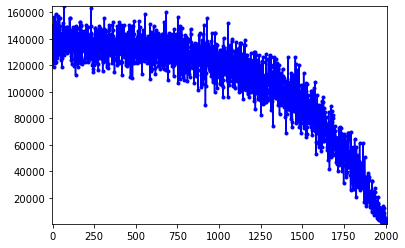

In [196]:
Procesar("TSPLIB", "ALL_tsp/att_euc2d/kroB100.tsp", "SIMPLES", T=2000, C=0.03)
# el costo óptimo segun TSPLIB es kroB100 : 22141

sumatoria de deltasE: 19155366.69703555
cant_iteraciones: 2000
deltaE promedio: 9577.683348517776
Kinicial calculado: 4.7888416742588875
el costo del mejor recorrido es: 41409.4295405404
el mejor recorrido es: [42, 10, 24, 48, 5, 29, 2, 26, 4, 35, 45, 32, 39, 25, 21, 47, 11, 12, 15, 33, 46, 44, 7, 6, 37, 19, 17, 27, 43, 30, 28, 18, 36, 20, 13, 14, 23, 3, 22, 16, 8, 1, 9, 38, 31, 40, 41, 34]
siendo los costos: [936.3845363951714, 921.4342081776647, 1638.227395693284, 303.78446306550967, 893.0671867222533, 1203.184108937614, 1849.1565644909574, 319.845275094068, 1426.011570780546, 460.1836589884521, 3295.5828012659613, 532.6321432283261, 966.632298239615, 1061.6896910114556, 710.721464428928, 710.769301531798, 585.4314648188974, 405.2949543233915, 496.32751283804527, 421.37987612129746, 743.8548245457578, 481.27435003332556, 742.8250130414295, 206.11889772653063, 131.46862743635836, 476.615148731133, 369.2709032675063, 286.40006983239374, 399.5409866334116, 557.9838707346297, 398.9009902

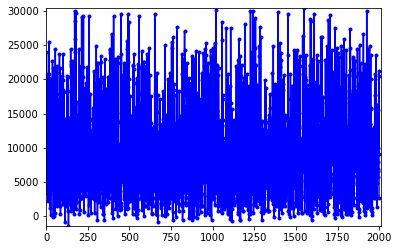

In [142]:
Procesar("TSPLIB", "ALL_tsp/att_euc2d/att48.tsp", "SIMPLE", T=2000, C=0.3)
# el costo óptimo segun TSPLIB es att48 : 10628

sumatoria de deltasE: 178887480.91401178
cant_iteraciones: 2000
deltaE promedio: 89443.74045700589
Kinicial calculado: 44.721870228502944
el costo del mejor recorrido es: 39246.40758548071
el mejor recorrido es: [5, 48, 39, 32, 21, 47, 11, 23, 14, 25, 13, 12, 15, 33, 46, 44, 18, 7, 28, 36, 30, 6, 37, 19, 27, 43, 17, 20, 40, 9, 1, 8, 38, 31, 22, 16, 3, 34, 41, 29, 2, 42, 10, 24, 45, 35, 26, 4]
siendo los costos: [303.78446306550967, 999.6449369651207, 532.6321432283261, 1239.6531773040394, 710.721464428928, 710.769301531798, 502.1324526457138, 605.1264330699825, 418.8006685763527, 532.0761223734814, 1298.3412494409934, 405.2949543233915, 496.32751283804527, 421.37987612129746, 743.8548245457578, 354.13274347340433, 167.91962362987834, 266.925083122587, 355.88340787398334, 734.4011165568854, 260.4611295375953, 206.11889772653063, 131.46862743635836, 201.357890334598, 286.40006983239374, 436.790567663726, 2358.315076489993, 1473.471071992932, 675.0029629564599, 462.0822437618654, 562.3041

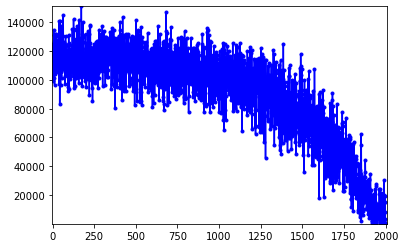

In [144]:
Procesar("TSPLIB", "ALL_tsp/att_euc2d/att48.tsp", "SIMPLES", T=2000, C=0.3)

sumatoria de deltasE: 334647306.62389785
cant_iteraciones: 2000
deltaE promedio: 167323.65331194893
Kinicial calculado: 83.66182665597447
el costo del mejor recorrido es: 35029.65323705963
el mejor recorrido es: [48, 103, 128, 84, 11, 52, 150, 96, 87, 144, 97, 81, 45, 33, 100, 74, 57, 36, 14, 143, 93, 49, 18, 29, 37, 120, 16, 135, 146, 127, 51, 63, 44, 66, 105, 19, 99, 141, 10, 92, 136, 69, 3, 73, 118, 59, 41, 89, 122, 21, 102, 23, 35, 2, 68, 30, 77, 115, 80, 147, 65, 130, 107, 13, 79, 110, 64, 20, 55, 42, 67, 31, 47, 6, 149, 54, 134, 75, 22, 112, 8, 106, 17, 25, 90, 34, 145, 109, 98, 148, 88, 28, 39, 38, 71, 124, 72, 83, 62, 138, 113, 108, 114, 126, 101, 56, 119, 5, 43, 86, 133, 50, 95, 94, 123, 91, 70, 111, 121, 76, 131, 139, 129, 104, 15, 27, 85, 1, 53, 137, 125, 46, 142, 132, 32, 117, 24, 61, 26, 78, 9, 82, 7, 12, 40, 116, 4, 60, 140, 58]
siendo los costos: [116.45600027478189, 105.01904589168576, 155.0290295396317, 94.64142856064674, 27.202941017470888, 190.06577808748213, 171.563

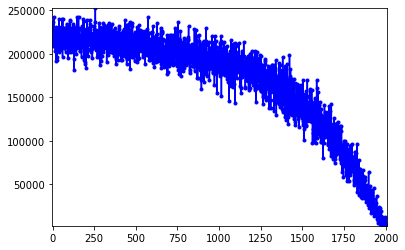

In [197]:
Procesar("TSPLIB", "ALL_tsp/att_euc2d/kroB150.tsp", "SIMPLES", T=2000, C=0.03)
# el costo óptimo segun TSPLIB es kroB150 : 26130

sumatoria de deltasE: 446813440.83508945
cant_iteraciones: 2000
deltaE promedio: 223406.7204175447
Kinicial calculado: 111.70336020877235
el costo del mejor recorrido es: 37203.65734314525
el mejor recorrido es: [153, 24, 18, 105, 77, 103, 183, 140, 106, 159, 50, 164, 177, 143, 171, 88, 22, 23, 104, 144, 193, 160, 55, 191, 154, 163, 54, 116, 52, 58, 84, 7, 57, 94, 180, 176, 27, 61, 35, 172, 157, 131, 199, 178, 74, 165, 60, 186, 196, 43, 89, 185, 118, 14, 125, 120, 42, 109, 2, 155, 13, 126, 187, 63, 31, 48, 195, 156, 121, 82, 64, 33, 147, 15, 112, 128, 51, 110, 78, 17, 192, 41, 148, 102, 200, 92, 151, 19, 137, 96, 119, 36, 45, 162, 135, 130, 44, 16, 182, 83, 4, 6, 87, 114, 168, 133, 66, 145, 34, 169, 72, 37, 184, 141, 65, 124, 127, 188, 79, 113, 179, 81, 47, 173, 139, 115, 20, 80, 38, 152, 108, 166, 138, 86, 49, 134, 181, 30, 75, 150, 101, 100, 56, 26, 69, 62, 132, 5, 197, 67, 40, 117, 190, 189, 111, 68, 10, 123, 142, 85, 122, 73, 53, 170, 149, 70, 198, 39, 194, 21, 90, 1, 95, 98, 174, 

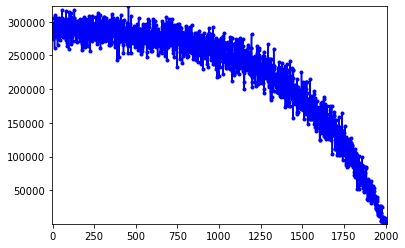

In [198]:
Procesar("TSPLIB", "ALL_tsp/att_euc2d/kroB200.tsp", "SIMPLES", T=2000, C=0.03)
# el costo óptimo segun TSPLIB es kroB200 : 29437

sumatoria de deltasE: 159173591.45303804
cant_iteraciones: 2000
deltaE promedio: 79586.79572651902
Kinicial calculado: 39.79339786325951
el costo del mejor recorrido es: 8298.129853507548
el mejor recorrido es: [537, 513, 536, 560, 559, 561, 562, 539, 538, 515, 514, 492, 516, 493, 494, 495, 496, 519, 520, 521, 522, 523, 524, 502, 501, 503, 526, 504, 528, 529, 506, 505, 481, 480, 479, 457, 456, 455, 454, 477, 476, 453, 452, 451, 450, 473, 472, 471, 448, 447, 446, 468, 445, 444, 467, 443, 442, 441, 419, 418, 396, 397, 398, 399, 400, 401, 402, 425, 426, 427, 428, 429, 406, 407, 408, 431, 432, 433, 434, 435, 436, 437, 414, 413, 389, 412, 411, 388, 410, 387, 409, 386, 363, 364, 341, 365, 342, 343, 319, 320, 344, 345, 368, 367, 390, 391, 366, 340, 339, 338, 337, 336, 313, 312, 311, 310, 309, 332, 331, 308, 330, 307, 306, 284, 283, 261, 260, 259, 258, 235, 234, 256, 254, 231, 232, 233, 210, 211, 212, 189, 188, 187, 186, 209, 208, 185, 162, 163, 140, 139, 141, 118, 95, 117, 116, 93, 94, 71, 70

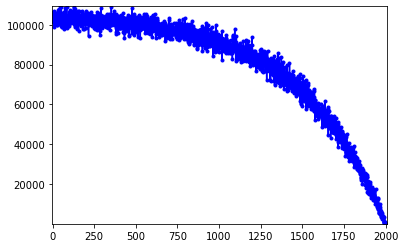

In [199]:
Procesar("TSPLIB", "ALL_tsp/att_euc2d/rat575.tsp", "SIMPLES", T=2000, C=0.03)
# el costo óptimo segun TSPLIB es rat575 : 6773

sumatoria de deltasE: 4646
cant_iteraciones: 2000
deltaE promedio: 2.323
Kinicial calculado: 0.0011615
el costo del mejor recorrido es: 7
el mejor recorrido es: [4, 1, 2, 3]
siendo los costos: [2, 2, 1, 2]
la semilla para dicho recorrido fue: 1594153896182


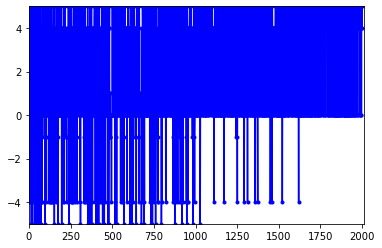

In [150]:
Procesar("TSP_IN", "TSP/AGD_TSP_IN_04.txt", "SIMPLE", T=2000, C=0.0019)

sumatoria de deltasE: 0
cant_iteraciones: 2000
deltaE promedio: 0.0
Kinicial calculado: 0.0
el costo del mejor recorrido es: 10
el mejor recorrido es: [1, 2, 3, 4, 5]
siendo los costos: [2, 2, 2, 2, 2]
la semilla para dicho recorrido fue: 1594154047871


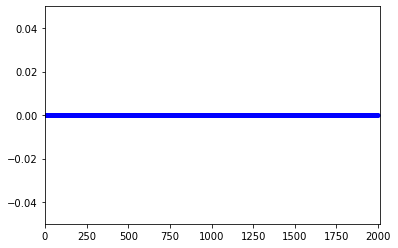

In [157]:
Procesar("TSP_IN", "TSP/AGD_TSP_IN_05.txt", "SIMPLE", T=2000, C=0.0015)

sumatoria de deltasE: 12933
cant_iteraciones: 2000
deltaE promedio: 6.4665
Kinicial calculado: 0.00323325
el costo del mejor recorrido es: 11
el mejor recorrido es: [4, 6, 3, 1, 5, 2]
siendo los costos: [2, 2, 2, 2, 2, 1]
la semilla para dicho recorrido fue: 1594154097798


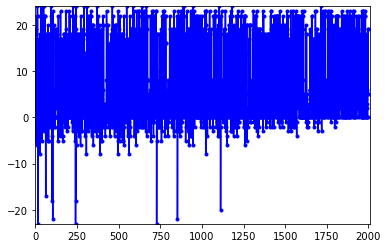

In [159]:
Procesar("TSP_IN", "TSP/AGD_TSP_IN_06.txt", "SIMPLE", T=2000, C=0.0034)

sumatoria de deltasE: 12556
cant_iteraciones: 2000
deltaE promedio: 6.278
Kinicial calculado: 0.003139
el costo del mejor recorrido es: 25
el mejor recorrido es: [5, 7, 6, 4, 2, 1, 3]
siendo los costos: [1, 4, 2, 4, 3, 5, 6]
la semilla para dicho recorrido fue: 1594154126926


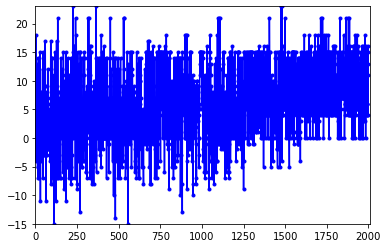

In [160]:
Procesar("TSP_IN", "TSP/AGD_TSP_IN_07.txt", "SIMPLE", T=2000, C=0.0034)

sumatoria de deltasE: 11320
cant_iteraciones: 2000
deltaE promedio: 5.66
Kinicial calculado: 0.00283
el costo del mejor recorrido es: 41
el mejor recorrido es: [5, 1, 2, 4, 6, 7, 8, 3]
siendo los costos: [4, 1, 4, 2, 11, 4, 9, 6]
la semilla para dicho recorrido fue: 1594154149037


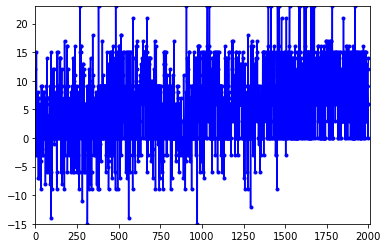

In [161]:
Procesar("TSP_IN", "TSP/AGD_TSP_IN_08.txt", "SIMPLE", T=2000, C=0.0034)

sumatoria de deltasE: 11862
cant_iteraciones: 2000
deltaE promedio: 5.931
Kinicial calculado: 0.0029655
el costo del mejor recorrido es: 36
el mejor recorrido es: [6, 9, 3, 1, 8, 4, 5, 2, 7]
siendo los costos: [1, 2, 2, 7, 10, 7, 3, 1, 3]
la semilla para dicho recorrido fue: 1594154176598


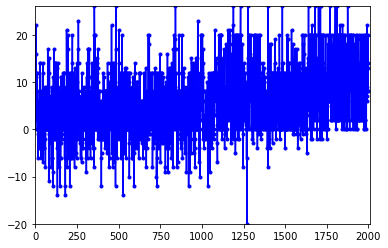

In [162]:
Procesar("TSP_IN", "TSP/AGD_TSP_IN_09.txt", "SIMPLE", T=2000, C=0.0034)

sumatoria de deltasE: 31176
cant_iteraciones: 2000
deltaE promedio: 15.588
Kinicial calculado: 0.007794
el costo del mejor recorrido es: 32
el mejor recorrido es: [4, 5, 2, 7, 6, 9, 3, 1, 8, 10]
siendo los costos: [7, 3, 1, 3, 1, 2, 2, 7, 1, 5]
la semilla para dicho recorrido fue: 1594154309913


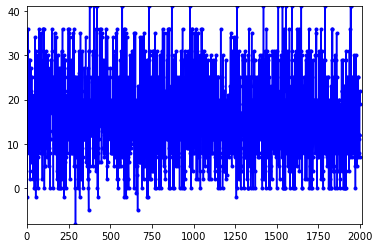

In [171]:
Procesar("TSP_IN", "TSP/AGD_TSP_IN_10.txt", "SIMPLE", T=2000, C=0.001)

sumatoria de deltasE: 31720
cant_iteraciones: 2000
deltaE promedio: 15.86
Kinicial calculado: 0.00793
el costo del mejor recorrido es: 34
el mejor recorrido es: [1, 5, 2, 7, 6, 9, 11, 10, 8, 4, 3]
siendo los costos: [4, 3, 1, 3, 1, 1, 3, 1, 10, 5, 2]
la semilla para dicho recorrido fue: 1594154351348


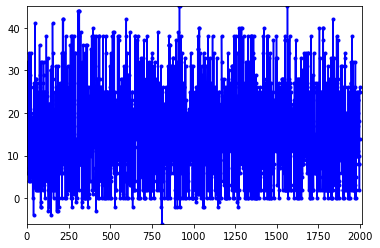

In [172]:
Procesar("TSP_IN", "TSP/AGD_TSP_IN_11.txt", "SIMPLE", T=2000, C=0.001)

sumatoria de deltasE: 49616
cant_iteraciones: 2000
deltaE promedio: 24.808
Kinicial calculado: 0.012404
el costo del mejor recorrido es: 30
el mejor recorrido es: [5, 4, 3, 2, 1]
siendo los costos: [5, 7, 6, 5, 7]
la semilla para dicho recorrido fue: 1594154384622


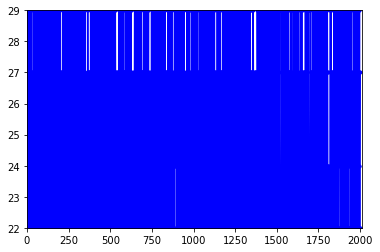

In [173]:
Procesar("TSP_IN", "TSP/TSP_IN_01.txt", "SIMPLE", T=2000, C=0.001)

sumatoria de deltasE: 108534
cant_iteraciones: 2000
deltaE promedio: 54.267
Kinicial calculado: 0.0271335
el costo del mejor recorrido es: 35
el mejor recorrido es: [3, 1, 7, 6, 5, 4, 2]
siendo los costos: [5, 5, 5, 5, 5, 5, 5]
la semilla para dicho recorrido fue: 1594154502451


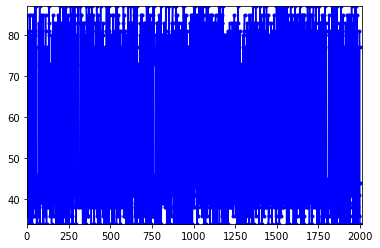

In [174]:
Procesar("TSP_IN", "TSP/TSP_IN_02.txt", "SIMPLE", T=2000, C=0.001)

sumatoria de deltasE: 37770
cant_iteraciones: 2000
deltaE promedio: 18.885
Kinicial calculado: 0.009442500000000001
el costo del mejor recorrido es: 31
el mejor recorrido es: [5, 4, 3, 6, 2, 1]
siendo los costos: [4, 3, 5, 7, 5, 7]
la semilla para dicho recorrido fue: 1594154537296


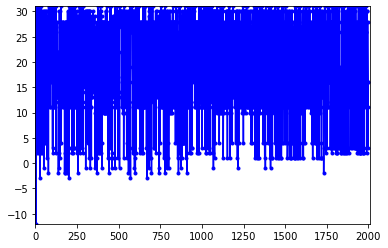

In [175]:
Procesar("TSP_IN", "TSP/TSP_IN_03.txt", "SIMPLE", T=2000, C=0.001)

sumatoria de deltasE: 0
cant_iteraciones: 2000
deltaE promedio: 0.0
Kinicial calculado: 0.0
el costo del mejor recorrido es: 30
el mejor recorrido es: [5, 1, 2, 3, 4, 6]
siendo los costos: [5, 5, 5, 5, 5, 5]
la semilla para dicho recorrido fue: 1594154578177


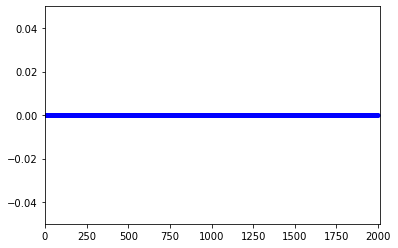

In [176]:
Procesar("TSP_IN", "TSP/TSP_IN_04.txt", "SIMPLE", T=2000, C=0.001)

sumatoria de deltasE: 194525
cant_iteraciones: 2000
deltaE promedio: 97.2625
Kinicial calculado: 0.04863125
el costo del mejor recorrido es: 83
el mejor recorrido es: [5, 11, 10, 1, 9, 12, 4, 3, 8, 7, 6, 2]
siendo los costos: [5, 5, 9, 5, 8, 10, 6, 4, 7, 9, 5, 10]
la semilla para dicho recorrido fue: 1594154589164


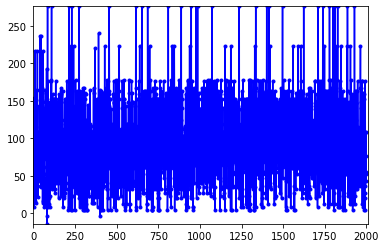

In [177]:
Procesar("TSP_IN", "TSP/TSP_IN_05.txt", "SIMPLE", T=2000, C=0.001)

sumatoria de deltasE: 97293
cant_iteraciones: 2000
deltaE promedio: 48.6465
Kinicial calculado: 0.02432325
el costo del mejor recorrido es: 76
el mejor recorrido es: [6, 1, 9, 3, 8, 2, 7, 4, 5]
siendo los costos: [6, 5, 8, 6, 9, 5, 20, 4, 13]
la semilla para dicho recorrido fue: 1594154633113


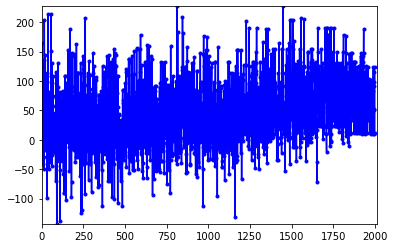

In [182]:
Procesar("TSP_IN", "TSP/TSP_IN_06.txt", "SIMPLE", T=2000, C=0.03)

sumatoria de deltasE: 5574
cant_iteraciones: 2000
deltaE promedio: 2.787
Kinicial calculado: 0.0013935
el costo del mejor recorrido es: 10
el mejor recorrido es: [2, 1, 10, 9, 8, 7, 6, 5, 4, 3]
siendo los costos: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
la semilla para dicho recorrido fue: 1594154640707


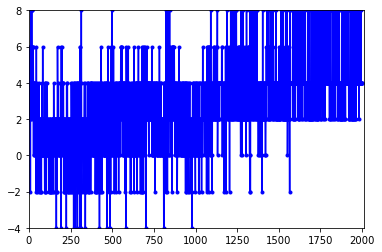

In [183]:
Procesar("TSP_IN", "TSP/TSP_IN_07.txt", "SIMPLE", T=2000, C=0.001)

sumatoria de deltasE: 40597
cant_iteraciones: 2000
deltaE promedio: 20.2985
Kinicial calculado: 0.01014925
el costo del mejor recorrido es: 143
el mejor recorrido es: [3, 9, 2, 1, 10, 4, 8, 6, 5, 7]
siendo los costos: [20, 20, 1, 1, 1, 20, 20, 20, 20, 20]
la semilla para dicho recorrido fue: 1594154653757


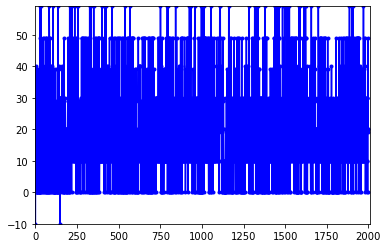

In [184]:
Procesar("TSP_IN", "TSP/TSP_IN_08.txt", "SIMPLE", T=2000, C=0.001)

sumatoria de deltasE: 16668
cant_iteraciones: 2000
deltaE promedio: 8.334
Kinicial calculado: 0.004167
el costo del mejor recorrido es: 10
el mejor recorrido es: [2, 1, 10, 9, 8, 7, 6, 5, 4, 3]
siendo los costos: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
la semilla para dicho recorrido fue: 1594154691378


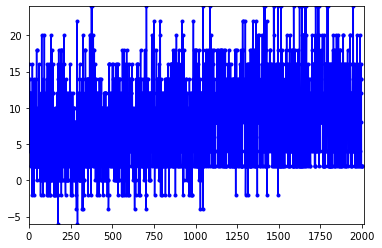

In [185]:
Procesar("TSP_IN", "TSP/TSP_IN_09.txt", "SIMPLE", T=2000, C=0.001)

sumatoria de deltasE: 7856
cant_iteraciones: 2000
deltaE promedio: 3.928
Kinicial calculado: 0.001964
el costo del mejor recorrido es: 17
el mejor recorrido es: [5, 7, 9, 10, 8, 6, 4, 2, 1, 3]
siendo los costos: [2, 2, 1, 1, 2, 2, 2, 1, 2, 2]
la semilla para dicho recorrido fue: 1594154713046


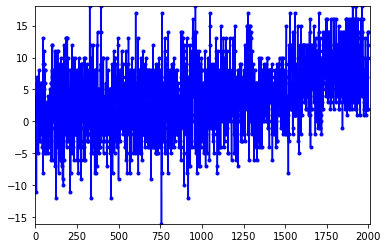

In [187]:
Procesar("TSP_IN", "TSP/TSP_IN_10.txt", "SIMPLE", T=2000, C=0.0034)

sumatoria de deltasE: 6323
cant_iteraciones: 2000
deltaE promedio: 3.1615
Kinicial calculado: 0.0015807500000000001
el costo del mejor recorrido es: 15
el mejor recorrido es: [3, 5, 7, 9, 11, 13, 1, 2, 4, 6, 8, 10, 12, 14, 15]
siendo los costos: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
la semilla para dicho recorrido fue: 1594154737430


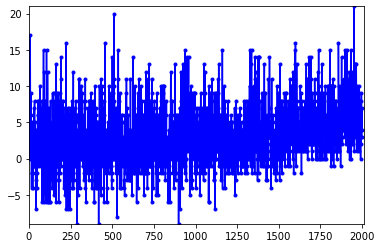

In [189]:
Procesar("TSP_IN", "TSP/TSP_IN_11.txt", "SIMPLE", T=2000, C=0.0023)

sumatoria de deltasE: 1868
cant_iteraciones: 2000
deltaE promedio: 0.934
Kinicial calculado: 0.000467
el costo del mejor recorrido es: 15
el mejor recorrido es: [8, 4, 12, 7, 3, 11, 6, 2, 15, 10, 5, 1, 14, 9, 13]
siendo los costos: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
la semilla para dicho recorrido fue: 1594154777081


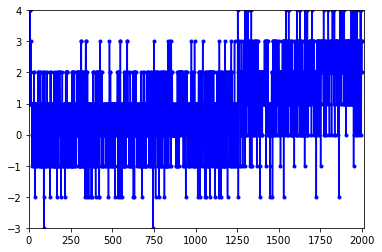

In [192]:
Procesar("TSP_IN", "TSP/TSP_IN_12.txt", "SIMPLE", T=2000, C=0.001)

In [47]:
'''
Las siguientes celdas del Notebook se mantienen para un futuro redesarrollo
'''

# Desarrollo de la lectura del archivo del tipo TSPLIB

archivo = "ALL_tsp/att_euc2d/att48.tsp"
arch = open(archivo)
# Las primeras 3 lineas del archivo se obvian
for a in range(3):
    arch.readline()
# Se lee la dimension del problema
cantCiu = int(arch.readline().split("DIMENSION: ")[1])
# Las siguientes 2 lineas del archivo se obvian
for a in range(2):
    arch.readline()

vec_ciudades = []
vec_ciudades_map = []

line = arch.readline()
aux = [a for a in line.split(' ') if a is not '' and a is not '\n']
while (line != 'EOF\n'):
    vec_ciudades.append([int(a) for a in aux])
    line = arch.readline()
    aux = [a for a in line.split(' ') if a is not '' and a is not '\n']

# Se arman las tuplas de ciudades [(nro1, [x1, y1]),(nro2, [x2, y2]),...]
vec_ciudades_map.append(map(lambda e: (e[0], e[1:]), vec_ciudades))

# Se arma la lista de las tuplas de ciudades
vec_ciudades_list = [list(a) for a in vec_ciudades_map][0]
arch.close()

vec_costCiu = []
aux = [a for a in vec_ciudades_list]
ciudad_actual = aux.pop(0)
for b in aux:
    costo_x = (ciudad_actual[1][0] - b[1][0])**2
    costo_y = (ciudad_actual[1][1] - b[1][1])**2
    costo = (costo_x+costo_y)**(1/2)
    vec_costCiu.append(costo)

print(vec_costCiu)
'''
Se calculan los costos entre las ciudades (resultando como en A*)
vec_costCiu = []
aux = [a for a in vec_ciudades_list]
while (len(aux) > 0):
    ciudad_actual = aux.pop(0)
    for b in aux:
        costo_x = (ciudad_actual[1][0] - b[1][0])**2
        costo_y = (ciudad_actual[1][1] - b[1][1])**2
        costo = (costo_x+costo_y)**(1/2)
        vec_costCiu.append(costo)
'''
a = 2

[4726.653149957166, 1204.3492018513568, 6362.502102160753, 3656.991249647721, 3129.520889848796, 2413.5223222502004, 562.3041881401916, 462.0822437618654, 5653.503338638795, 1712.356563336036, 1603.5663378856516, 2367.1977103740196, 2200.3654241966265, 1289.4452295464123, 1003.8849535678877, 3832.687046968484, 2257.5989457828864, 3418.9039179245738, 2266.984781598677, 2956.020466776237, 719.9569431570196, 1699.3133907552192, 5278.156591083671, 2577.884791840008, 6075.466237252907, 3464.6784843618607, 2653.682912482198, 3624.6459137410925, 3114.9210262862202, 1573.1576526209953, 3950.066455137179, 1747.3591502607585, 2141.2381931957034, 6754.234967781325, 2382.115026609756, 3305.89594512592, 1028.9047574970193, 3529.2883135272473, 824.3136538963794, 2187.0002286236736, 4819.396227744716, 3488.9872456058074, 1946.9003569777267, 6834.318181062395, 1541.7292239560097, 2378.534422706554, 3743.0792136955906]


In [151]:
# Desarrollo de la funcion que calcula los costos de un recorrido

mat_costCiu = [
    [ 0, 3, 6, 9,12, 3, 6, 9,12],
    [ 3, 0, 6, 7, 8, 1, 2, 2, 3],
    [ 6, 6, 0, 3,10, 8, 5, 1, 2],
    [ 9, 7, 3, 0, 5,19,21, 5, 1],
    [12, 8,10, 5, 0, 8,25, 1,45],
    [ 3, 1, 8,19, 8, 0, 9, 8, 7],
    [ 6, 2, 5,21,25, 9, 0, 1, 1],
    [ 9, 2, 1, 5, 1, 8, 1, 0, 4],
    [12, 3, 2, 1,45, 7, 1, 4, 0]
    ]

cantCiu = 9
n_ciudad_inicio = 2
aux = [a for a in mat_costCiu]
recorrido = []
ciudad_actual = n_ciudad_inicio
recorrido.append(ciudad_actual)
print(recorrido)
print(aux[ciudad_actual-1])
while (len(recorrido) < cantCiu):
    for a in recorrido:
        aux[ciudad_actual-1][a-1] = -1

    ciudad_actual = 1 + aux[ciudad_actual-1].index(min([a for a in aux[ciudad_actual-1] if (a is not -1 and a is not 0)]))
    recorrido.append(ciudad_actual)
    print(recorrido)
    print(aux[ciudad_actual-1])

def calcularCostoRecorrido(mat_costCiu, recorrido_actual):
    costo_rec_actual = 0
    costo = 0
    costos = []
    for a in range(len(recorrido_actual)-1):
        costo = mat_costCiu[recorrido_actual[a]-1][recorrido_actual[a+1]-1]
        costos.append(costo)
        costo_rec_actual += costo
    costo = mat_costCiu[recorrido_actual[-1:][0]-1][recorrido_actual[0]-1]
    costos.append(costo)
    costo_rec_actual += costo
    return costo_rec_actual, costos

aux = [a for a in mat_costCiu]
print(calcularCostoRecorrido(aux,recorrido))

[2]
[3, 0, 6, 7, 8, 1, 2, 2, 3]
[2, 6]
[3, 1, 8, 19, 8, 0, 9, 8, 7]
[2, 6, 1]
[0, 3, 6, 9, 12, 3, 6, 9, 12]
[2, 6, 1, 3]
[6, 6, 0, 3, 10, 8, 5, 1, 2]
[2, 6, 1, 3, 8]
[9, 2, 1, 5, 1, 8, 1, 0, 4]
[2, 6, 1, 3, 8, 5]
[12, 8, 10, 5, 0, 8, 25, 1, 45]
[2, 6, 1, 3, 8, 5, 4]
[9, 7, 3, 0, 5, 19, 21, 5, 1]
[2, 6, 1, 3, 8, 5, 4, 9]
[12, 3, 2, 1, 45, 7, 1, 4, 0]
[2, 6, 1, 3, 8, 5, 4, 9, 7]
[6, 2, 5, 21, 25, 9, 0, 1, 1]
(21, [1, 3, 6, 1, 1, 5, 1, 1, 2])


In [160]:
# intento fallido de la creacion de una perturbacion con inmovilización de pares de recorridos

mat_costCiu = [
    [ 0, 3, 6, 9,12, 3, 6, 9,12],
    [ 3, 0, 6, 7, 8, 1, 2, 2, 3],
    [ 6, 6, 0, 3,10, 8, 5, 1, 2],
    [ 9, 7, 3, 0, 5,19,21, 5, 1],
    [12, 8,10, 5, 0, 8,25, 1,45],
    [ 3, 1, 8,19, 8, 0, 9, 8, 7],
    [ 6, 2, 5,21,25, 9, 0, 1, 1],
    [ 9, 2, 1, 5, 1, 8, 1, 0, 4],
    [12, 3, 2, 1,45, 7, 1, 4, 0]
    ]
cantCiu = 9
recorrido_actual = [2, 6, 1, 3, 8, 5, 4, 9, 7]
costo_rec_actual = 21
costos_actual = [1, 3, 6, 1, 1, 5, 1, 1, 2]
t = 5
T = 20
factor_de_aprendizaje = 0.3

# Se reformula la lista de recorridos para tener la informacion necesaria en la toma de decision
rec_actual_redundante = []
for a in range(0,len(recorrido_actual)-1):
    rec_actual_redundante.append((costos_actual[a],[recorrido_actual[a],recorrido_actual[a+1]]))
rec_actual_redundante.append((costos_actual[a],[recorrido_actual[a+1],recorrido_actual[0]]))

# Se obtienen la cantidad de recorridos a mezclar
if (t/T > factor_de_aprendizaje):
    N = cantCiu #ayudo capacidad de exploración en las 2/3 partes del proceso
else:
    t = t/factor_de_aprendizaje
    N = int((cantCiu*t)/T)-1

# Se obtienen los cantCiu-N menores recorridos a persistir y se convierte a ciudades a inmovilizar en la proxima solucion
aux = [a for a in rec_actual_redundante]
# TODO: ver si el comentar el Sort facilita capacidad de exploracion
aux.sort(reverse=False)

ciudades_a_inmovilizar = []
for a in [a[1] for a in aux[:cantCiu-N]]:
    for b in a:
        ciudades_a_inmovilizar.append(b)
# Se filtran las ciudades duplicadas
ciudades_a_inmovilizar = list(set(ciudades_a_inmovilizar))
# una opcion para mantener el orden de las ciudades durante el filtrado:
#aux_set = set()
#ciudades_a_inmovilizar = [x for x in ciudades_a_inmovilizar if x not in used and (used.add(x) or True)]

ciudades_a_mezclar = []
for a in [a[1] for a in aux[cantCiu-N:]]:
    for b in a:
        if (b not in ciudades_a_inmovilizar):
            ciudades_a_mezclar.append(b)
# Se filtran las ciudades duplicadas
ciudades_a_mezclar = list(set(ciudades_a_mezclar))

# Se genera un recorrido posible
recorrido_posible = []
for a in recorrido_actual:
    if (a in ciudades_a_inmovilizar):
        recorrido_posible.append(a)
    else:
        ciudad = ciudades_a_mezclar.pop(random.randint(0,len(ciudades_a_mezclar)-1))
        recorrido_posible.append(ciudad)

'''
while (len(aux) > (cantCiu - N)):
    indice_anterior = aux.index(min(aux)))
    if (indice == len(aux)):
        # es el ultimo indice
        indice_posterior = 0

        recorridos_a_persistir.append(rec_actual_redundante[indice])
'''
# Se pasan los recorridos a persistir a ciudades a inmovilizar en la proxima solucion

a=4

In [69]:
# Desarrollo de una función para crear el primer recorrido de forma pseudoaleatoria

import matplotlib as plt
import random
import pickle
import os
import json
import logging
from datetime import datetime, timedelta

matriz = [
    [ 0, 3, 6, 9,12, 3, 6, 9,12],
    [ 3, 0, 6, 7, 8, 1, 2, 2, 3],
    [ 6, 6, 0, 3,10, 8, 5, 1, 2],
    [ 9, 7, 3, 0, 5,19,21, 5, 1],
    [12, 8,10, 5, 0, 8,25, 1,45],
    [ 3, 1, 8,19, 8, 0, 9, 8, 7],
    [ 6, 2, 5,21,25, 9, 0, 1, 1],
    [ 9, 2, 1, 5, 1, 8, 1, 0, 4],
    [12, 3, 2, 1,45, 7, 1, 4, 0]
    ]
cantCiu = 9
n_ciudad_inicio = 2
aux = []
for a in matriz:
    vec = []
    for b in a:
        vec.append(b)
    aux.append(vec)

recorrido = []
ciudad_actual = n_ciudad_inicio
recorrido.append(ciudad_actual)
while (len(recorrido) < cantCiu):
    for a in recorrido:
        aux[ciudad_actual-1][a-1] = -1
    ciudad_actual = 1 + aux[ciudad_actual-1].index(min([a for a in aux[ciudad_actual-1] if (a is not -1 and a is not 0)]))
    recorrido.append(ciudad_actual)
print(recorrido)

recorrido_actual = recorrido
# Se intercambian 2 ciudades tomadas al azar en el recorrido
recorrido_posible = [a for a in recorrido_actual]

x = random.randint(0,len(recorrido_posible)-1)
y = x
while (x == y):
    y = random.randint(0,len(recorrido_posible)-1)
aux = recorrido_posible[x]
recorrido_posible[x] = recorrido_posible[y]
recorrido_posible[y] = aux
print(recorrido_posible)


def generarPrimerCamino_azar(cantCiu):
    recorrido = []
    for a in range(cantCiu):
        ciudad = random.randint(1,cantCiu)
        while ciudad in recorrido:
            ciudad = random.randint(1,cantCiu)
        recorrido.append(ciudad)
    return recorrido
print(generarPrimerCamino_azar(cantCiu))




[2, 6, 1, 3, 8, 5, 4, 9, 7]
[2, 6, 1, 3, 7, 5, 4, 9, 8]
[7, 3, 9, 5, 4, 1, 6, 8, 2]


In [46]:
# Desarrollo de una función para perturbar al sistema del modo "STANDARD" planteado por CROES en 1958

import math
import random
T = 2000
t = 2000
cantCiu = 5

recorrido_actual = [1,2,3,4,5]

recorrido_posible = [a for a in recorrido_actual]
# se duplica el vector para simplificar el intercambio, luego se extrae teniendo en cuenta dicha perturbacion
for a in recorrido_actual:
    recorrido_posible.append(a)

print(recorrido_posible)

largo = 3
indice = 1
#largo = math.ceil(t/(T/8)+1)
#indice = random.randint(0,cantCiu-1)
print(indice,largo)

# se genera la mascara de intercambio (con largo duplicado - 1)
vec_mascara = []
for a in range(2*cantCiu-1):
    if (a < indice):
        vec_mascara.append(0)
    elif (a < (indice+largo)):
        vec_mascara.append(1)
    else:
        vec_mascara.append(0)
print(vec_mascara)
recorrido_posible_aux = recorrido_posible[indice:indice+largo]
print(recorrido_posible_aux)
recorrido_posible_aux.reverse()
print(recorrido_posible_aux)
recorrido_posible[indice:indice+largo] = recorrido_posible_aux
print(recorrido_posible)
recorrido_final = recorrido_posible[indice:indice+cantCiu]
print(recorrido_final)


[1, 2, 3, 4, 5, 1, 2, 3, 4, 5]
1 3
[0, 1, 1, 1, 0, 0, 0, 0, 0]
[2, 3, 4]
[4, 3, 2]
[1, 4, 3, 2, 5, 1, 2, 3, 4, 5]
[4, 3, 2, 5, 1]
